# Notebook for prediction result analysis with figures

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"]=300
import torch
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr,spearmanr

from src.utils import reconst_pair_idx

def discritize(logit,thresh=0.5):
    pred = 1 if logit>=thresh else 0
    return pred


In [4]:
data_dir=f"/home/ksuga/whole_mrna_predictor/UTR_PairPred/results/runs/MLP_split_large_ave_cdhit09_model_mod"
score_path=os.path.join(data_dir,"score_dict.pkl")
preds_path=os.path.join(data_dir,"pred_results.pkl")

with open(score_path,"rb") as f:
    score=pickle.load(f)
with open(preds_path,"rb") as f:
    pred_results=pickle.load(f) # [pair_idx_list,preds,out_labels,out_logits]

print(score)


{'accuracy': 0.6476190476190476, 'precision': 0.6288819875776398, 'recall': 0.7223543400713437, 'f1': 0.6723851687880464, 'confusion_matrix': array([[ 961,  717],
       [ 467, 1215]]), 'fpr_all': array([0.        , 0.        , 0.        , ..., 0.9988081 , 0.99940405,
       1.        ]), 'tpr_all': array([0.00000000e+00, 5.94530321e-04, 1.18906064e-03, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00]), 'roc_thresh': array([1.9599217 , 0.9599217 , 0.9481485 , ..., 0.01610078, 0.00884438,
       0.00631139], dtype=float32), 'auc_roc': 0.7005420217432281}


In [5]:
## For contrastive learning
data_dir=f"./results/runs/multi_contrastive_each_species_out_pred"
score_path=os.path.join(data_dir,"score_dict.pkl")
preds_path=os.path.join(data_dir,"pred_results.pkl")

with open(score_path,"rb") as f:
    score=pickle.load(f)

with open(preds_path,"rb") as f:
    pred_results=pickle.load(f) # (out_cos_sim,out_logits,pair_idx_list)

print(score)


{'accuracy': 0.6469323394495413, 'precision': 0.6027777777777777, 'recall': 0.8682480708773935, 'f1': 0.711558730530507, 'confusion_matrix': array([[1475, 2002],
       [ 461, 3038]]), 'fpr_all': array([0.        , 0.        , 0.        , ..., 0.99942479, 0.9997124 ,
       1.        ]), 'tpr_all': array([0.00000000e+00, 2.85795942e-04, 5.71591883e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00]), 'roc_thresh': array([1.9983335 , 0.9983334 , 0.99817824, ..., 0.01899686, 0.01810399,
       0.01800194], dtype=float32), 'auc_roc': 0.7247736996716182}


In [3]:
## For contrastive learning
seq_df = pd.read_csv("./data/human/gencode44_utr_gene_unique_cdhit09.csv",index_col=0)
data_dir=f"./results/runs/contrastive_learning_seed5"
score_path=os.path.join(data_dir,"score_dict.pkl")
preds_path=os.path.join(data_dir,"pred_results.pkl")

with open(score_path,"rb") as f:
    score=pickle.load(f)

with open(preds_path,"rb") as f:
    pred_results=pickle.load(f) # (out_cos_sim,out_logits,pair_idx_list)

print(score)


{'accuracy': 0.6580357142857143, 'precision': 0.6137430644472898, 'recall': 0.8549346016646849, 'f1': 0.7145341614906832, 'confusion_matrix': array([[ 773,  905],
       [ 244, 1438]]), 'fpr_all': array([0.        , 0.        , 0.        , ..., 0.9988081 , 0.99940405,
       1.        ]), 'tpr_all': array([0.00000000e+00, 5.94530321e-04, 1.18906064e-03, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00]), 'roc_thresh': array([1.6996603 , 0.69966036, 0.6982985 , ..., 0.36262056, 0.36194405,
       0.35727412], dtype=float32), 'auc_roc': 0.728652889247292}


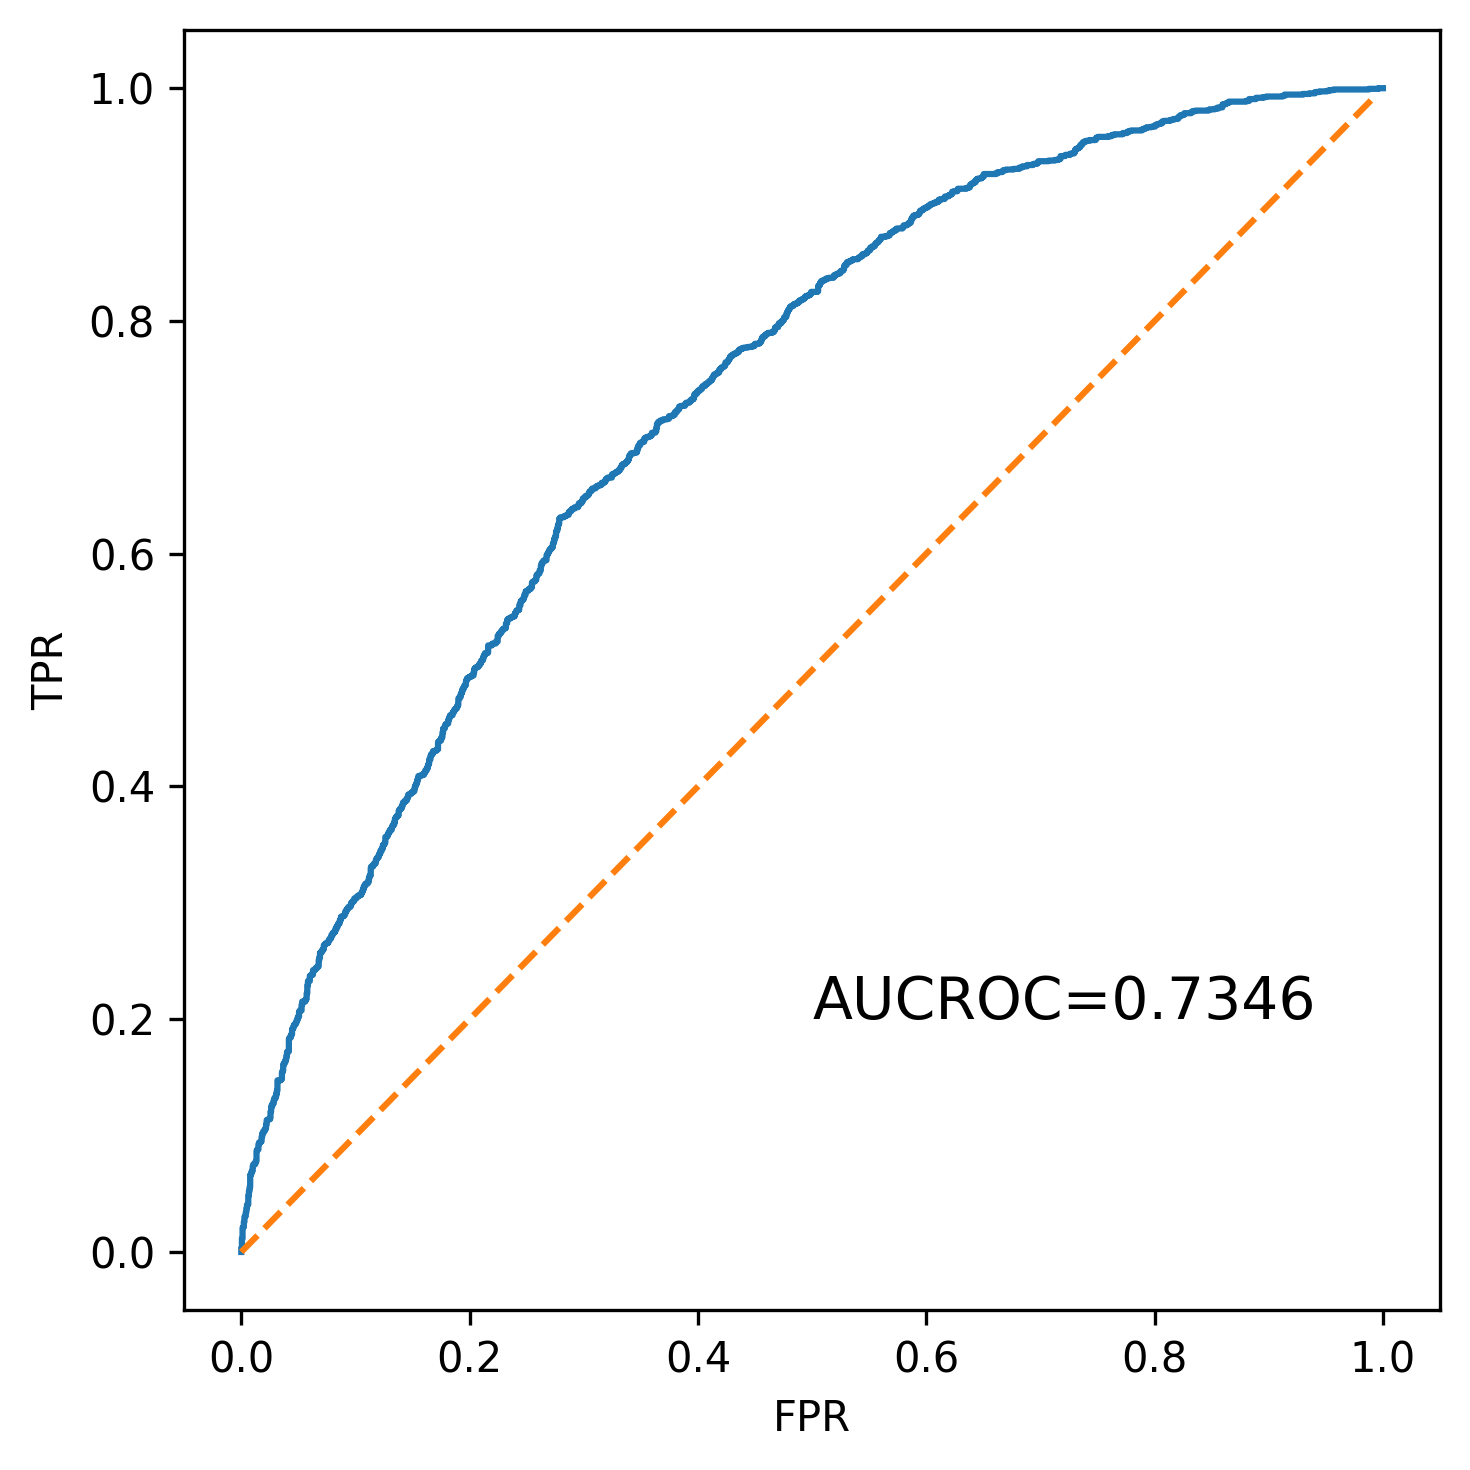

In [146]:
fig=plt.figure(figsize=(5,5))
line=np.arange(0,1,0.01)
auc_roc=score["auc_roc"]
plt.plot(score["fpr_all"],score["tpr_all"])
plt.plot(line,line,linestyle="--")
plt.text(0.5,0.2,f"AUCROC={score['auc_roc']:.4f}",fontsize=14)
#plt.title(os.path.basename(data_dir))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.tight_layout()
plt.savefig(f"./results/imgs/aucroc_{os.path.basename(data_dir)}")


## Multi result comparison

In [83]:
## Data setup
root_dir="./results/runs"
data_list=["contrastive_learing_10fold_shuffle_seed0/9","MLP_split_large_ave_10fold_shuffle_seed0","mouse_contrastive_learing_10fold_shuffle_seed0/9","mouse_contrastive_1e4"]
score_dic=dict()
pred_res_dic=dict()
for d in data_list:
    data_dir=os.path.join(root_dir,d)
    score_path=os.path.join(data_dir,"score_dict.pkl")
    preds_path=os.path.join(data_dir,"pred_results.pkl")

    with open(score_path,"rb") as f:
        score=pickle.load(f)
    with open(preds_path,"rb") as f:
        pred_results=pickle.load(f)
    
    score_dic[d]=score
    pred_res_dic[d]=pred_results


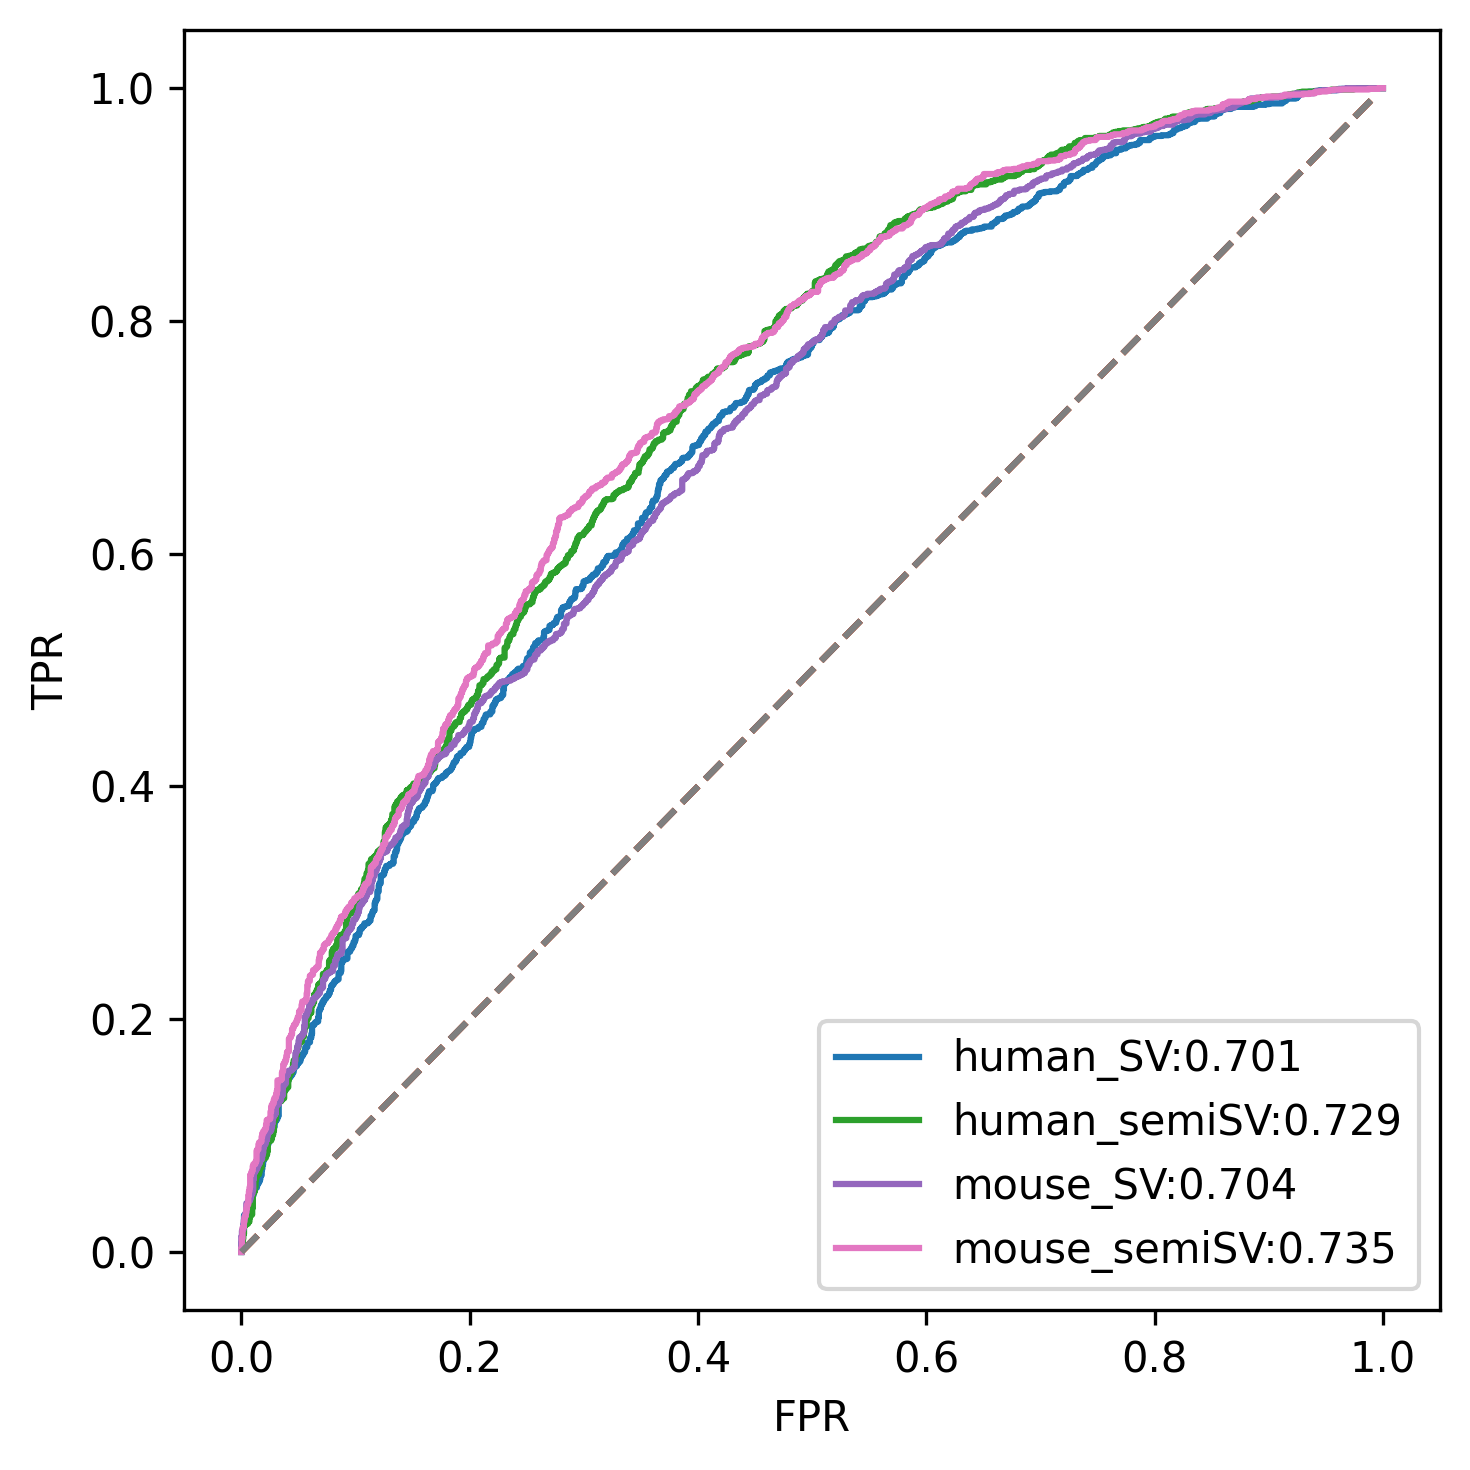

In [89]:
fig=plt.figure(figsize=(5,5))
line=np.arange(0,1,0.01)
label_list=["human_SV","human_semiSV","mouse_SV","mouse_semiSV"]
for (s_k,s_v),(p_k,p_v),l in zip(score_dic.items(),pred_res_dic.items(),label_list):
    auc_roc=s_v["auc_roc"]
    plt.plot(s_v["fpr_all"],s_v["tpr_all"],label=f"{l}:{auc_roc:.3f}")
    plt.plot(line,line,linestyle="--")
    #plt.text(0.5,0.2,f"AUCROC={auc_roc:.4f}",fontsize=14)
    #plt.title(os.path.basename(data_dir))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.tight_layout()
    plt.savefig(f"./results/imgs/aucroc_multi_comparison")


## Analysis prediction result

In [5]:
seq_df = pd.read_csv("./data/human/gencode44_utr_gene_unique_cdhit09.csv",index_col=0)
pair_idx = reconst_pair_idx(pred_results[0])
logits=pred_results[-1].reshape(-1)


In [6]:
df_pred_res=pd.DataFrame(pair_idx,columns=["utr5","utr3","label"])
df_pred_res["pred"] = pred_results[1]
df_pred_res["correct"] = (df_pred_res["label"]==df_pred_res["pred"]).values
df_pred_res["logits"] = logits
df_pred_res["ENST_ID"]=seq_df.iloc[df_pred_res.utr5.values]["ENST_ID"].values
df_pred_res["ENST_ID_PRE"]=list(map(lambda enst_id: enst_id.split(".")[0],df_pred_res["ENST_ID"].values))
df_pred_res["GENE"]=seq_df.iloc[df_pred_res.utr5.values]["GENE"].values
df_pred_res=pd.concat([df_pred_res,seq_df.iloc[:,-4:].iloc[df_pred_res.utr5.values].reset_index(drop=True)],axis=1)
df_pred_res.sort_values("logits",ascending=False,inplace=True)
#df_pred_res.to_csv(f"human_pred_analysis_seed{seed}.csv")
df_pred_res


,utr5,utr3,label,pred,correct,logits,ENST_ID,ENST_ID_PRE,GENE,total_len,5UTR_len,CDS_len,3UTR_len
1376,5466,5466,1,True,True,0.959922,ENST00000366958.9,ENST00000366958,PROX1,8468,578,2214,5676
1072,14074,14074,1,True,True,0.948148,ENST00000326652.9,ENST00000326652,TMEM150B,983,223,702,58
1233,3634,3634,1,True,True,0.924823,ENST00000378661.4,ENST00000378661,OXER1,1637,73,1155,409
847,7661,7661,1,True,True,0.923107,ENST00000409696.7,ENST00000409696,GNLY,858,282,393,183
1293,13672,13672,1,True,True,0.919601,ENST00000309017.8,ENST00000309017,PTPN7,3765,1089,1083,1593
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891,304,9096,0,False,True,0.017267,ENST00000484980.5,ENST00000484980,UNC119,4189,3162,438,589
3356,11231,14475,0,False,True,0.017058,ENST00000340339.4,ENST00000340339,ADGRG5,3767,523,1587,1657
2564,4182,5744,0,False,True,0.016101,ENST00000419580.6,ENST00000419580,ABI3,1718,314,1083,321
3044,3331,4678,0,False,True,0.008844,ENST00000408973.3,ENST00000408973,LCNL1,1836,594,495,747


In [53]:
topk=200
top_genes=df_pred_res[(df_pred_res["correct"]==True)&(df_pred_res["label"]==1)].iloc[:topk]["GENE"].values
meta_scape=pd.DataFrame({"Gene":top_genes,"OptionalDataColumns":np.arange(len(top_genes))})
meta_scape.to_csv(f"./results/analysis/human_top{topk}_related_genes_seed{seed}.csv",index=False)


In [58]:
gene_list=[]
for i in range(5):
    tmp_df=pd.read_csv(f"./results/analysis/human_top100_related_genes_seed{i+1}.csv")
    gene_list.extend(tmp_df["Gene"].values[:50])

df=pd.DataFrame({"Gene":gene_list,"optional":np.arange(len(gene_list))})
df.to_csv("./results/analysis/human_top_logits_5iter_allow_double.csv",index=False)


# Analysis prediction result for Contrastive Learning

In [4]:
## For contrastive learning
seed=5
seq_df = pd.read_csv("./data/human/gencode44_utr_gene_unique_cdhit09.csv",index_col=0)
data_dir=f"./results/runs/contrastive_learning_seed{seed}"
score_path=os.path.join(data_dir,"score_dict.pkl")
preds_path=os.path.join(data_dir,"pred_results.pkl")

with open(score_path,"rb") as f:
    score=pickle.load(f)

with open(preds_path,"rb") as f:
    pred_results=pickle.load(f) # (out_cos_sim,out_logits,pair_idx_list)

print(score)


{'accuracy': 0.6580357142857143, 'precision': 0.6137430644472898, 'recall': 0.8549346016646849, 'f1': 0.7145341614906832, 'confusion_matrix': array([[ 773,  905],
       [ 244, 1438]]), 'fpr_all': array([0.        , 0.        , 0.        , ..., 0.9988081 , 0.99940405,
       1.        ]), 'tpr_all': array([0.00000000e+00, 5.94530321e-04, 1.18906064e-03, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00]), 'roc_thresh': array([1.6996603 , 0.69966036, 0.6982985 , ..., 0.36262056, 0.36194405,
       0.35727412], dtype=float32), 'auc_roc': 0.728652889247292}


In [6]:
pair_idx = reconst_pair_idx(pred_results[-1])
logits=pred_results[1].reshape(-1)
cos_sim = pred_results[0].reshape(-1)


In [7]:
df_pred_res=pd.DataFrame(pair_idx,columns=["utr5","utr3","label"])
df_pred_res["pred"] = list(map(discritize,pred_results[1]))
df_pred_res["correct"] = (df_pred_res["label"]==df_pred_res["pred"]).values
df_pred_res["logits"] = logits
df_pred_res["cos_sim"] = cos_sim
df_pred_res["ENST_ID"]=seq_df.iloc[df_pred_res.utr5.values]["ENST_ID"].values
df_pred_res["ENST_ID_PRE"]=list(map(lambda enst_id: enst_id.split(".")[0],df_pred_res["ENST_ID"].values))
df_pred_res["GENE"]=seq_df.iloc[df_pred_res.utr5.values]["GENE"].values
df_pred_res=pd.concat([df_pred_res,seq_df.iloc[:,-4:].iloc[df_pred_res.utr5.values].reset_index(drop=True)],axis=1)
df_pred_res.sort_values("cos_sim",ascending=False,inplace=True)
#df_pred_res.to_csv(f"human_pred_analysis_seed{seed}.csv")
df_pred_res


,utr5,utr3,label,pred,correct,logits,cos_sim,ENST_ID,ENST_ID_PRE,GENE,total_len,5UTR_len,CDS_len,3UTR_len
1611,5622,5622,1,1,True,0.699660,0.845681,ENST00000353383.6,ENST00000353383,RAI1,7677,484,5721,1472
428,7056,7056,1,1,True,0.698299,0.839209,ENST00000706482.1,ENST00000706482,FOXG1,4673,1675,1470,1528
1615,8755,8755,1,1,True,0.697471,0.835284,ENST00000374037.8,ENST00000374037,SPDEF,1910,430,1008,472
908,2829,2829,1,1,True,0.696479,0.830589,ENST00000329402.4,ENST00000329402,GAST,465,62,306,97
772,14553,14553,1,1,True,0.695042,0.823799,ENST00000340107.9,ENST00000340107,FGFR3,4307,275,2427,1605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2813,6337,4868,0,0,True,0.369239,-0.535484,ENST00000397747.5,ENST00000397747,PDCD1LG2,2432,287,822,1323
2606,2941,4804,0,0,True,0.365413,-0.551948,ENST00000305877.13,ENST00000305877,BCR,6783,452,3816,2515
1832,3886,4652,0,0,True,0.362621,-0.564008,ENST00000625203.2,ENST00000625203,OR5L1,1110,100,936,74
2944,8999,6011,0,0,True,0.361944,-0.566936,ENST00000450662.7,ENST00000450662,EFCAB3,1694,71,1473,150


### 1. Analysis for Metascape

In [42]:
topk=200
top_genes=df_pred_res[(df_pred_res["correct"]==True)&(df_pred_res["label"]==1)].iloc[:topk]["GENE"].values
meta_scape=pd.DataFrame({"Gene":top_genes,"OptionalDataColumns":np.arange(len(top_genes))})
meta_scape.to_csv(f"./results/analysis/human_CL_top{topk}_related_genes_seed{seed}.csv",index=False)


In [43]:
gene_list=[]
for i in range(5):
    tmp_df=pd.read_csv(f"./results/analysis/human_CL_top200_related_genes_seed{i+1}.csv")
    gene_list.extend(tmp_df["Gene"].values[:50])

df=pd.DataFrame({"Gene":gene_list,"optional":np.arange(len(gene_list))})
df.to_csv("./results/analysis/human_CL_top_logits_5iter_allow_double.csv",index=False)

### 2. Analysis of corr between logits and TE

In [9]:
#te=pd.read_table("data/human/TE/df_counts_and_len.TE_sorted.HEK_Andrev2015.with_annot.txt",sep=" ")
te=pd.read_table("data/human/TE/df_counts_and_len.TE_sorted.pc3.with_annot.txt",sep=" ")
te=te.dropna()
te=te[(te["rpkm_riboseq"]>0.1)&(te["rpkm_rnaseq"]>5)]

te_enst=te["ensembl_tx_id"].values


In [4]:
## For multi set
flg=1
for i in range(5):
    dir  =f"./results/runs/contrastive_learning_seed{i+1}"
    pred_path = os.path.join(dir,"pred_results.pkl")
    with open(pred_path,"rb") as f:
        pred_results=pickle.load(f) # (out_cos_sim,out_logits,pair_idx_list)
        pair_idx = reconst_pair_idx(pred_results[-1])
        logits=pred_results[1].reshape(-1)
        cos_sim = pred_results[0].reshape(-1)

    df_pred_res=pd.DataFrame(pair_idx,columns=["utr5","utr3","label"])
    df_pred_res["pred"] = list(map(discritize,pred_results[1]))
    df_pred_res["correct"] = (df_pred_res["label"]==df_pred_res["pred"]).values
    df_pred_res["logits"] = logits
    df_pred_res["cos_sim"] = cos_sim
    df_pred_res["ENST_ID"]=seq_df.iloc[df_pred_res.utr5.values]["ENST_ID"].values
    df_pred_res["ENST_ID_PRE"]=list(map(lambda enst_id: enst_id.split(".")[0],df_pred_res["ENST_ID"].values))
    df_pred_res["GENE"]=seq_df.iloc[df_pred_res.utr5.values]["GENE"].values
    df_pred_res=pd.concat([df_pred_res,seq_df.iloc[:,-4:].iloc[df_pred_res.utr5.values].reset_index(drop=True)],axis=1)
    df_pred_res.sort_values("cos_sim",ascending=False,inplace=True)
    if flg:
        total_df = df_pred_res
        flg=0
    else:
        total_df = pd.concat([total_df,df_pred_res])
    
    total_df.sort_values("cos_sim",ascending=False,inplace=True)
    #total_df = total_df[(total_df["label"]==1)&(total_df["correct"]==1)]
target_df=total_df[~total_df.duplicated(subset="ENST_ID_PRE")]


985
pearson:-0.045861014152807876
spearman:-0.037205575460199064


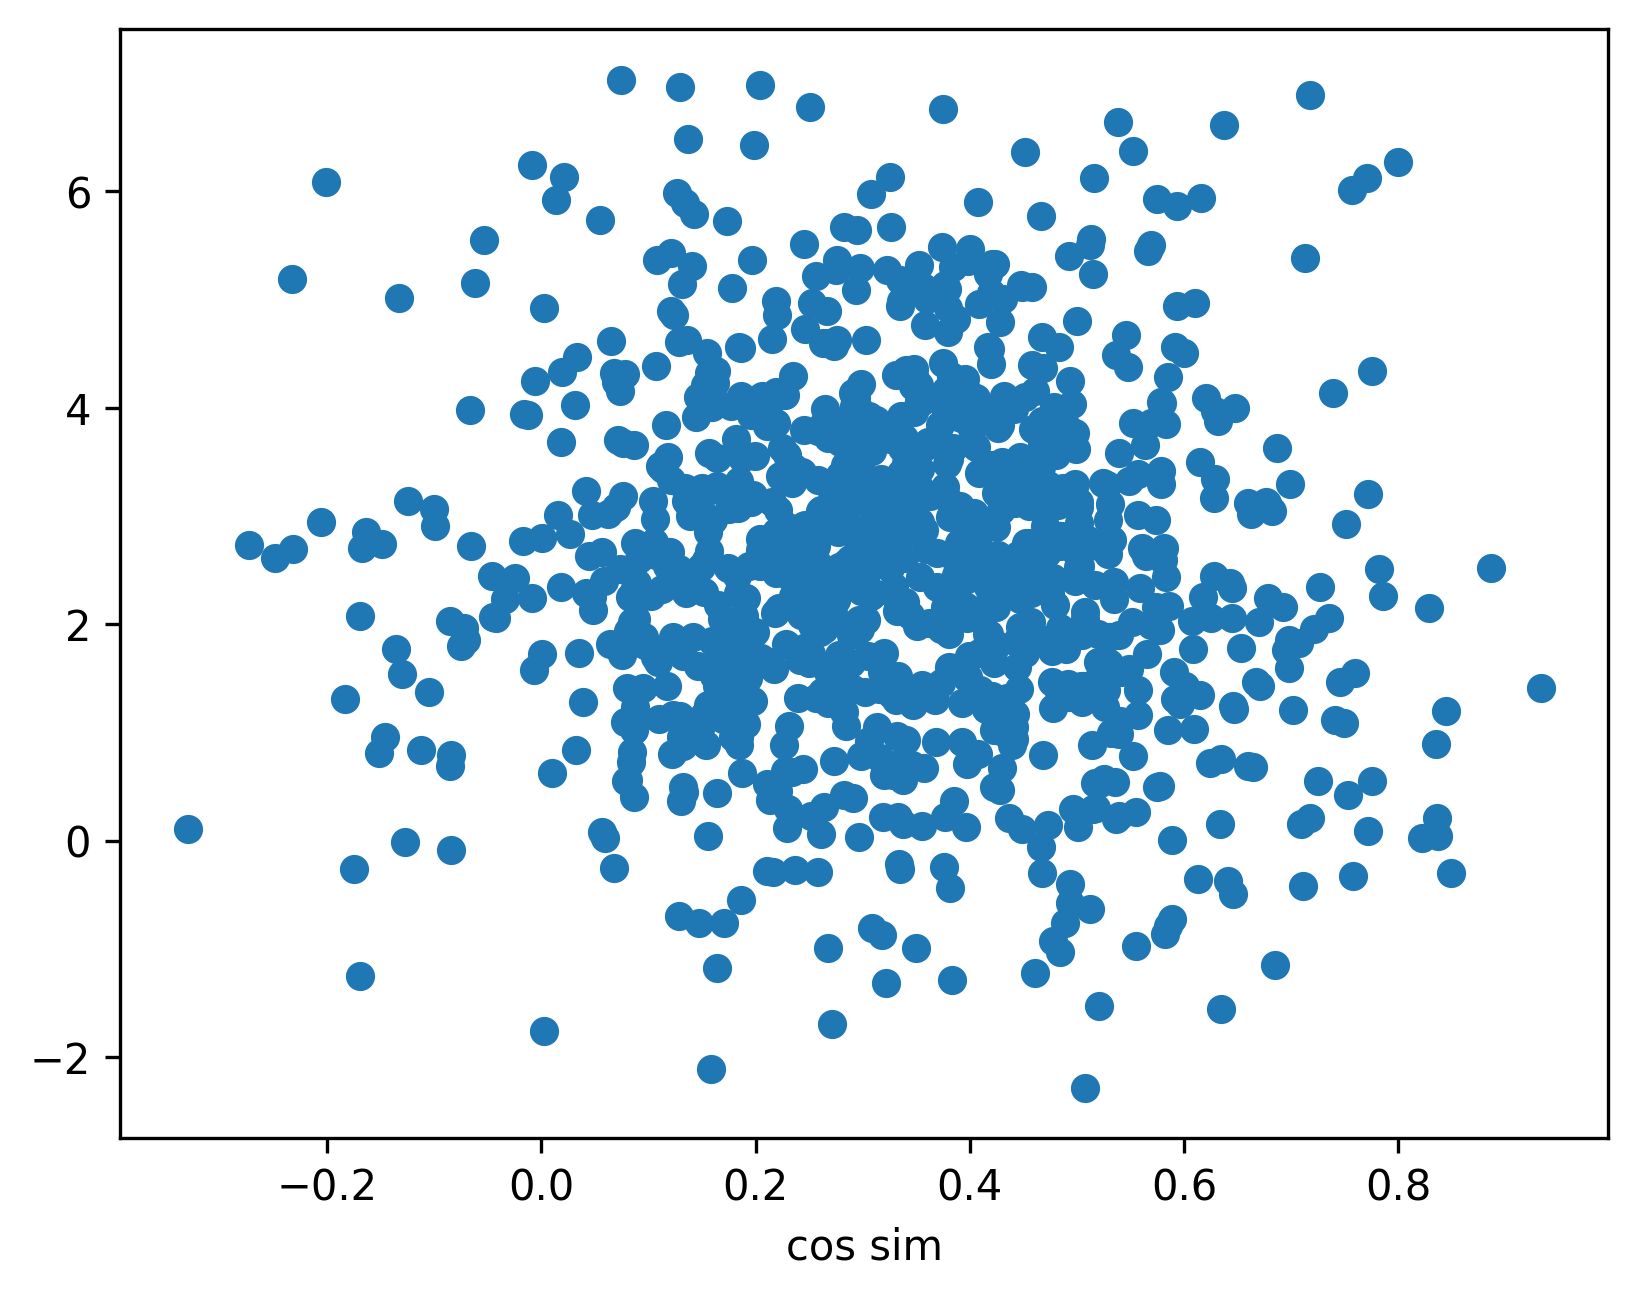

In [24]:
#target_df = df_pred_res[(df_pred_res["label"]==1)]
target_df_filt = target_df[target_df["label"]==1]
gencode_enst=target_df_filt["ENST_ID_PRE"].values
match_id=list(set(te_enst)&set(gencode_enst))
print(len(match_id))


pred_val=target_df_filt.set_index("ENST_ID_PRE").loc[match_id]["cos_sim"].values
log_te = np.log(te.set_index("ensembl_tx_id").loc[match_id]["rpkm_riboseq"].values)

plt.scatter(pred_val,log_te)
pearson,_ = pearsonr(pred_val,log_te)
spearman,_ = spearmanr(pred_val,log_te)
plt.xlabel("cos sim")
print(f"pearson:{pearson}")
print(f"spearman:{spearman}")


### 2.2 Analysis corr between TE from iwasaki lab

In [48]:
te_df = pd.read_csv("/home/ksuga/whole_mrna_predictor/UTR_PairPred/data/iwasaki_lab/Human_HEK293T/SIKT09/TE_HS_CT1.csv",index_col=0)
te_df.head()

,ENST_ID,CDS_len,count,TPM_ribo,TPM_rna,TE
0,ENST00000420190,358.0,9,2.188067,10.198418,0.214550
1,ENST00000437963,109.0,4,3.193997,23.925516,0.133498
2,ENST00000342066,682.0,58,7.401925,12.083438,0.612568
3,ENST00000616016,346.0,34,8.552713,11.155099,0.766709
4,ENST00000616125,574.0,49,7.429939,13.448308,0.552481


In [56]:
df_pred_res = target_df_filt[(target_df_filt['correct']==1)&(target_df_filt["cos_sim"]>0.7) ]
#df_pred_res = df_pred_res[(df_pred_res["label"]==1)&(df_pred_res["correct"]==1)]
df_pred_res=df_pred_res.drop("ENST_ID",axis=1).rename(columns={"ENST_ID_PRE":"ENST_ID"})

In [57]:
df_pred_res

,utr5,utr3,label,pred,correct,logits,cos_sim,ENST_ID,GENE,total_len,5UTR_len,CDS_len,3UTR_len
1156,7625,7625,1,1,True,0.717696,0.933061,ENST00000394166,NR2F2,5287,1406,1245,2636
1284,13869,13869,1,1,True,0.710732,0.898943,ENST00000397374,DUSP8,4824,479,1878,2467
514,3526,3526,1,1,True,0.710502,0.897822,ENST00000676793,SEMA6B,4021,346,2667,1008
1390,4439,4439,1,1,True,0.709246,0.891724,ENST00000443883,CACNA2D1,7757,497,3312,3948
947,5919,5919,1,1,True,0.709139,0.891206,ENST00000617146,SRCIN1,7065,247,3552,3266
...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,12601,12601,1,1,True,0.668827,0.702884,ENST00000255040,APCS,925,96,672,157
693,4512,4512,1,1,True,0.668669,0.702171,ENST00000290399,SIM2,4461,632,2004,1825
714,4669,4669,1,1,True,0.668358,0.700768,ENST00000507079,NFKB1,4153,512,2934,707
1596,10532,10532,1,1,True,0.668320,0.700598,ENST00000381668,ATP8A1,8270,232,3495,4543


In [58]:
df_concat=pd.merge(te_df,df_pred_res,on="ENST_ID",how="inner")
print(df_concat.shape)

(169, 18)


pearson:-0.09712590030462952
spearman:-0.11464082132525841


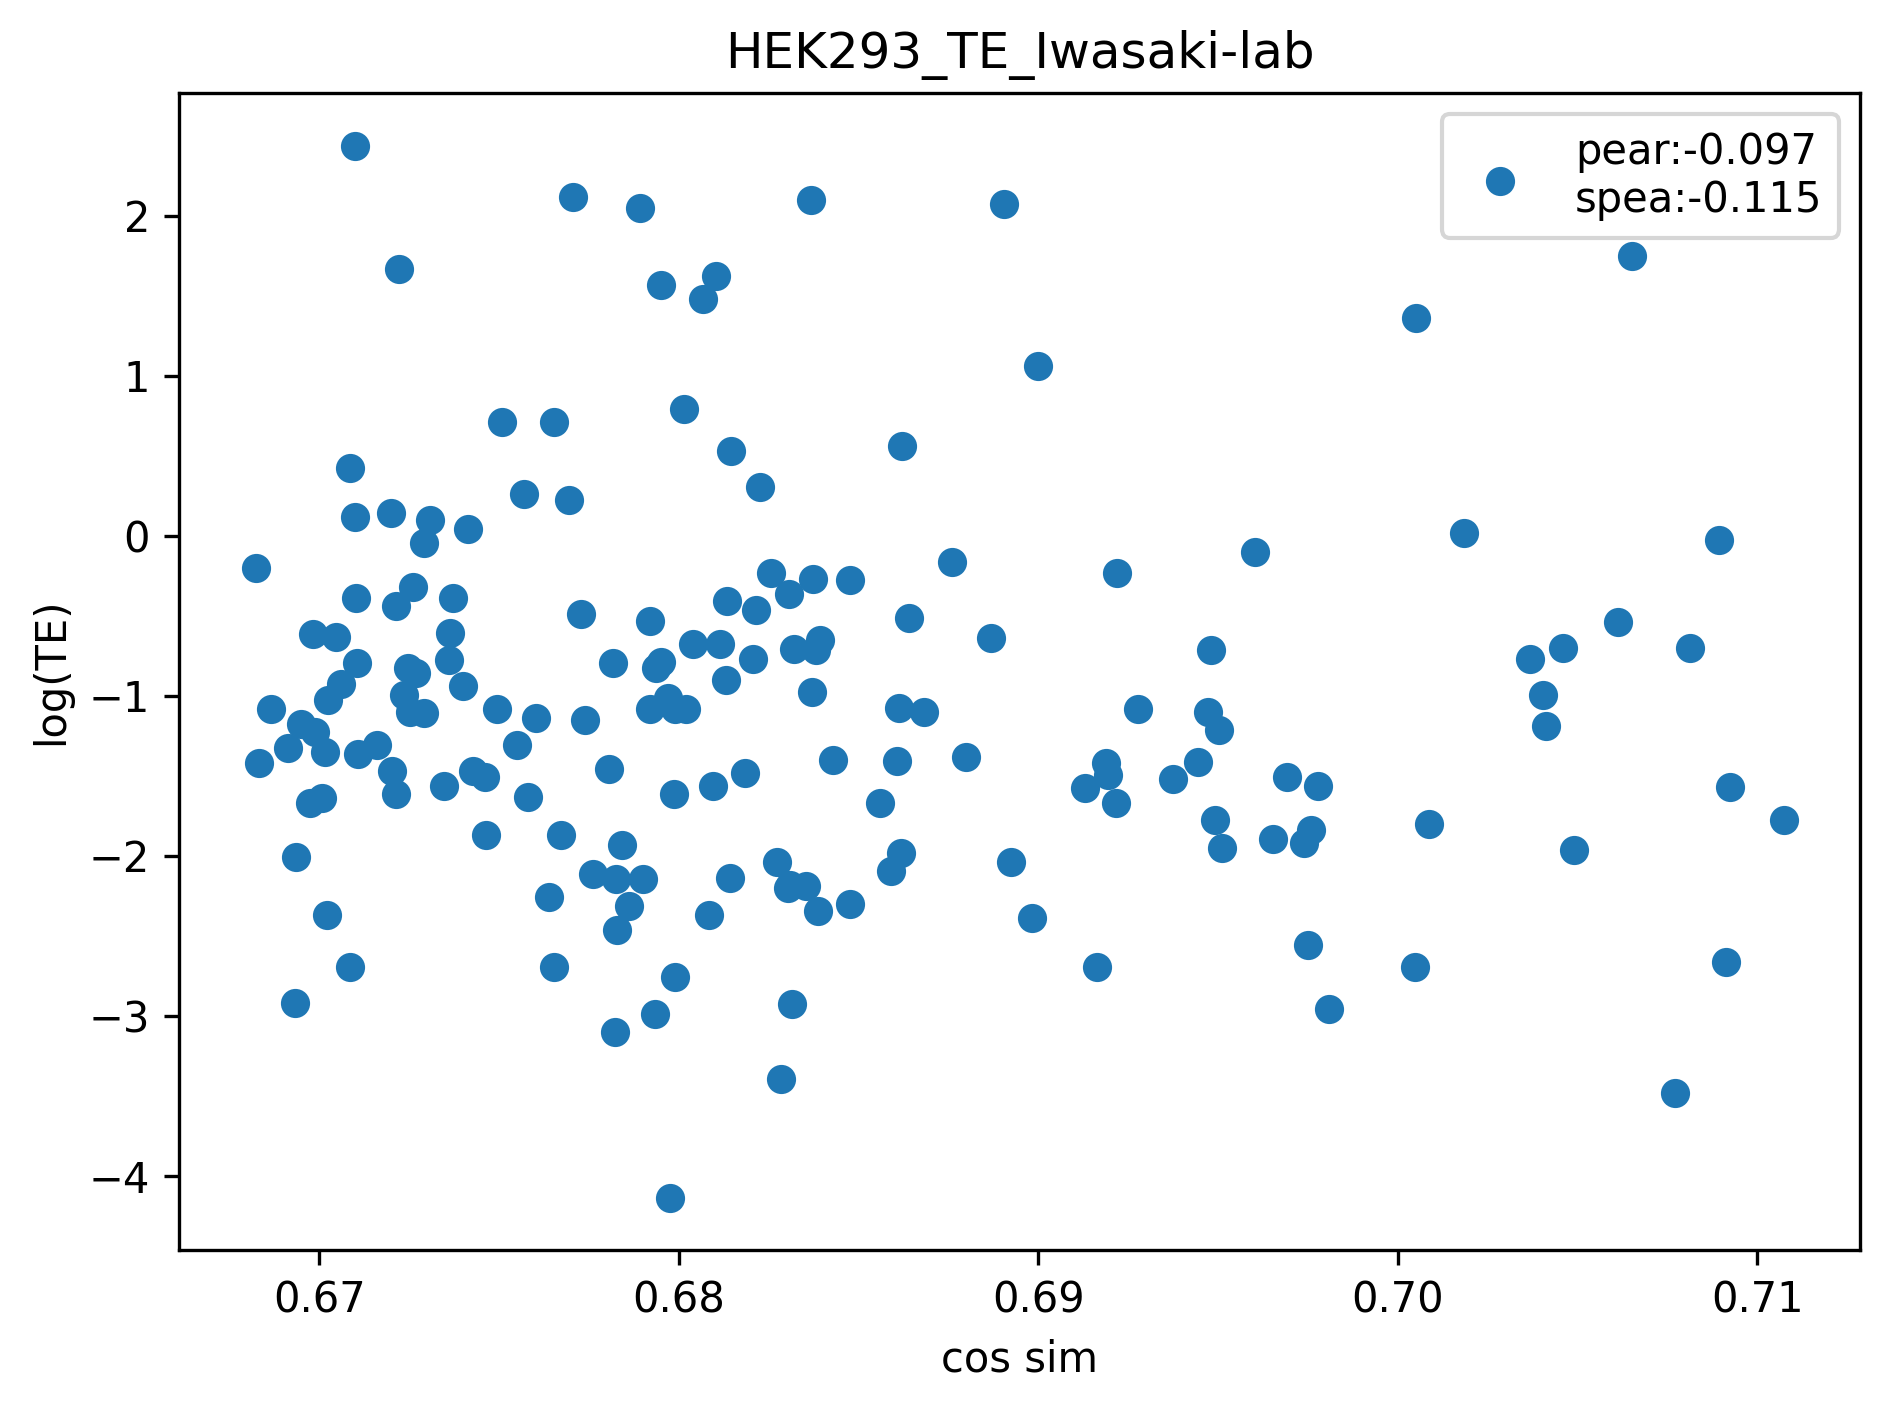

In [59]:
pred_val=df_concat["logits"].values
log_te = np.log(df_concat["TE"].values)

#plt.scatter(pred_val,log_te)
pearson,_ = pearsonr(pred_val,log_te)
spearman,_ = spearmanr(pred_val,log_te)
plt.scatter(pred_val,log_te,label=f"pear:{pearson:.3f}\nspea:{spearman:.3f}")
plt.xlabel("cos sim")
plt.ylabel("log(TE)")
plt.title("HEK293_TE_Iwasaki-lab")
plt.legend()
plt.tight_layout()
#plt.savefig("results/imgs/TE_corr_HEK293_iwasaki_lab")
print(f"pearson:{pearson}")
print(f"spearman:{spearman}")


In [61]:
df_pred_res

,utr5,utr3,label,pred,correct,logits,cos_sim,ENST_ID,GENE,total_len,5UTR_len,CDS_len,3UTR_len
1156,7625,7625,1,1,True,0.717696,0.933061,ENST00000394166,NR2F2,5287,1406,1245,2636
1284,13869,13869,1,1,True,0.710732,0.898943,ENST00000397374,DUSP8,4824,479,1878,2467
514,3526,3526,1,1,True,0.710502,0.897822,ENST00000676793,SEMA6B,4021,346,2667,1008
1390,4439,4439,1,1,True,0.709246,0.891724,ENST00000443883,CACNA2D1,7757,497,3312,3948
947,5919,5919,1,1,True,0.709139,0.891206,ENST00000617146,SRCIN1,7065,247,3552,3266
...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,12601,12601,1,1,True,0.668827,0.702884,ENST00000255040,APCS,925,96,672,157
693,4512,4512,1,1,True,0.668669,0.702171,ENST00000290399,SIM2,4461,632,2004,1825
714,4669,4669,1,1,True,0.668358,0.700768,ENST00000507079,NFKB1,4153,512,2934,707
1596,10532,10532,1,1,True,0.668320,0.700598,ENST00000381668,ATP8A1,8270,232,3495,4543


In [63]:
te_df = pd.read_csv("/home/ksuga/whole_mrna_predictor/UTR_PairPred/data/iwasaki_lab/Human_iPS/SIKT10/Human_iPS_IPSC1_TE.csv",index_col=0)
df_concat=pd.merge(te_df,df_pred_res,on="ENST_ID",how="inner")
print(df_concat.shape)

(169, 18)


In [64]:
df_concat

,ENST_ID,CDS_len_x,count,TPM_ribo,TPM_rna,TE,utr5,utr3,label,pred,correct,logits,cos_sim,GENE,total_len,5UTR_len,CDS_len_y,3UTR_len
0,ENST00000378888,696.0,76,2.661059,26.549428,0.100230,3611,3611,1,1,True,0.684773,0.775794,DVL1,3305,353,2088,864
1,ENST00000378602,195.0,29,3.624212,14.011359,0.258662,4245,4245,1,1,True,0.670153,0.708878,TMEM52,1118,241,585,292
2,ENST00000378536,729.0,288,9.627536,100.108235,0.096171,4456,4456,1,1,True,0.683884,0.771680,SKI,6083,448,2187,3448
3,ENST00000324856,2286.0,1114,11.875698,59.665378,0.199038,12606,12606,1,1,True,0.672140,0.717879,ARID1A,8595,389,6858,1348
4,ENST00000373347,980.0,137,3.406785,14.600183,0.233338,13191,13191,1,1,True,0.678067,0.744904,DLGAP3,3921,334,2940,647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,ENST00000614565,917.0,45,1.195896,2.587473,0.462187,12023,12023,1,1,True,0.682068,0.763291,CDH4,6678,253,2751,3674
165,ENST00000245663,590.0,216,8.921788,47.283651,0.188687,370,370,1,1,True,0.669749,0.707050,ZBTB46,5231,201,1770,3260
166,ENST00000290399,668.0,1,0.036482,0.107635,0.338937,4512,4512,1,1,True,0.668669,0.702171,SIM2,4461,632,2004,1825
167,ENST00000397748,573.0,1,0.042530,0.627403,0.067787,7055,7055,1,1,True,0.670853,0.712047,FTCD,1955,44,1719,192


pearson:-0.09712590030462952
spearman:-0.11464082132525841


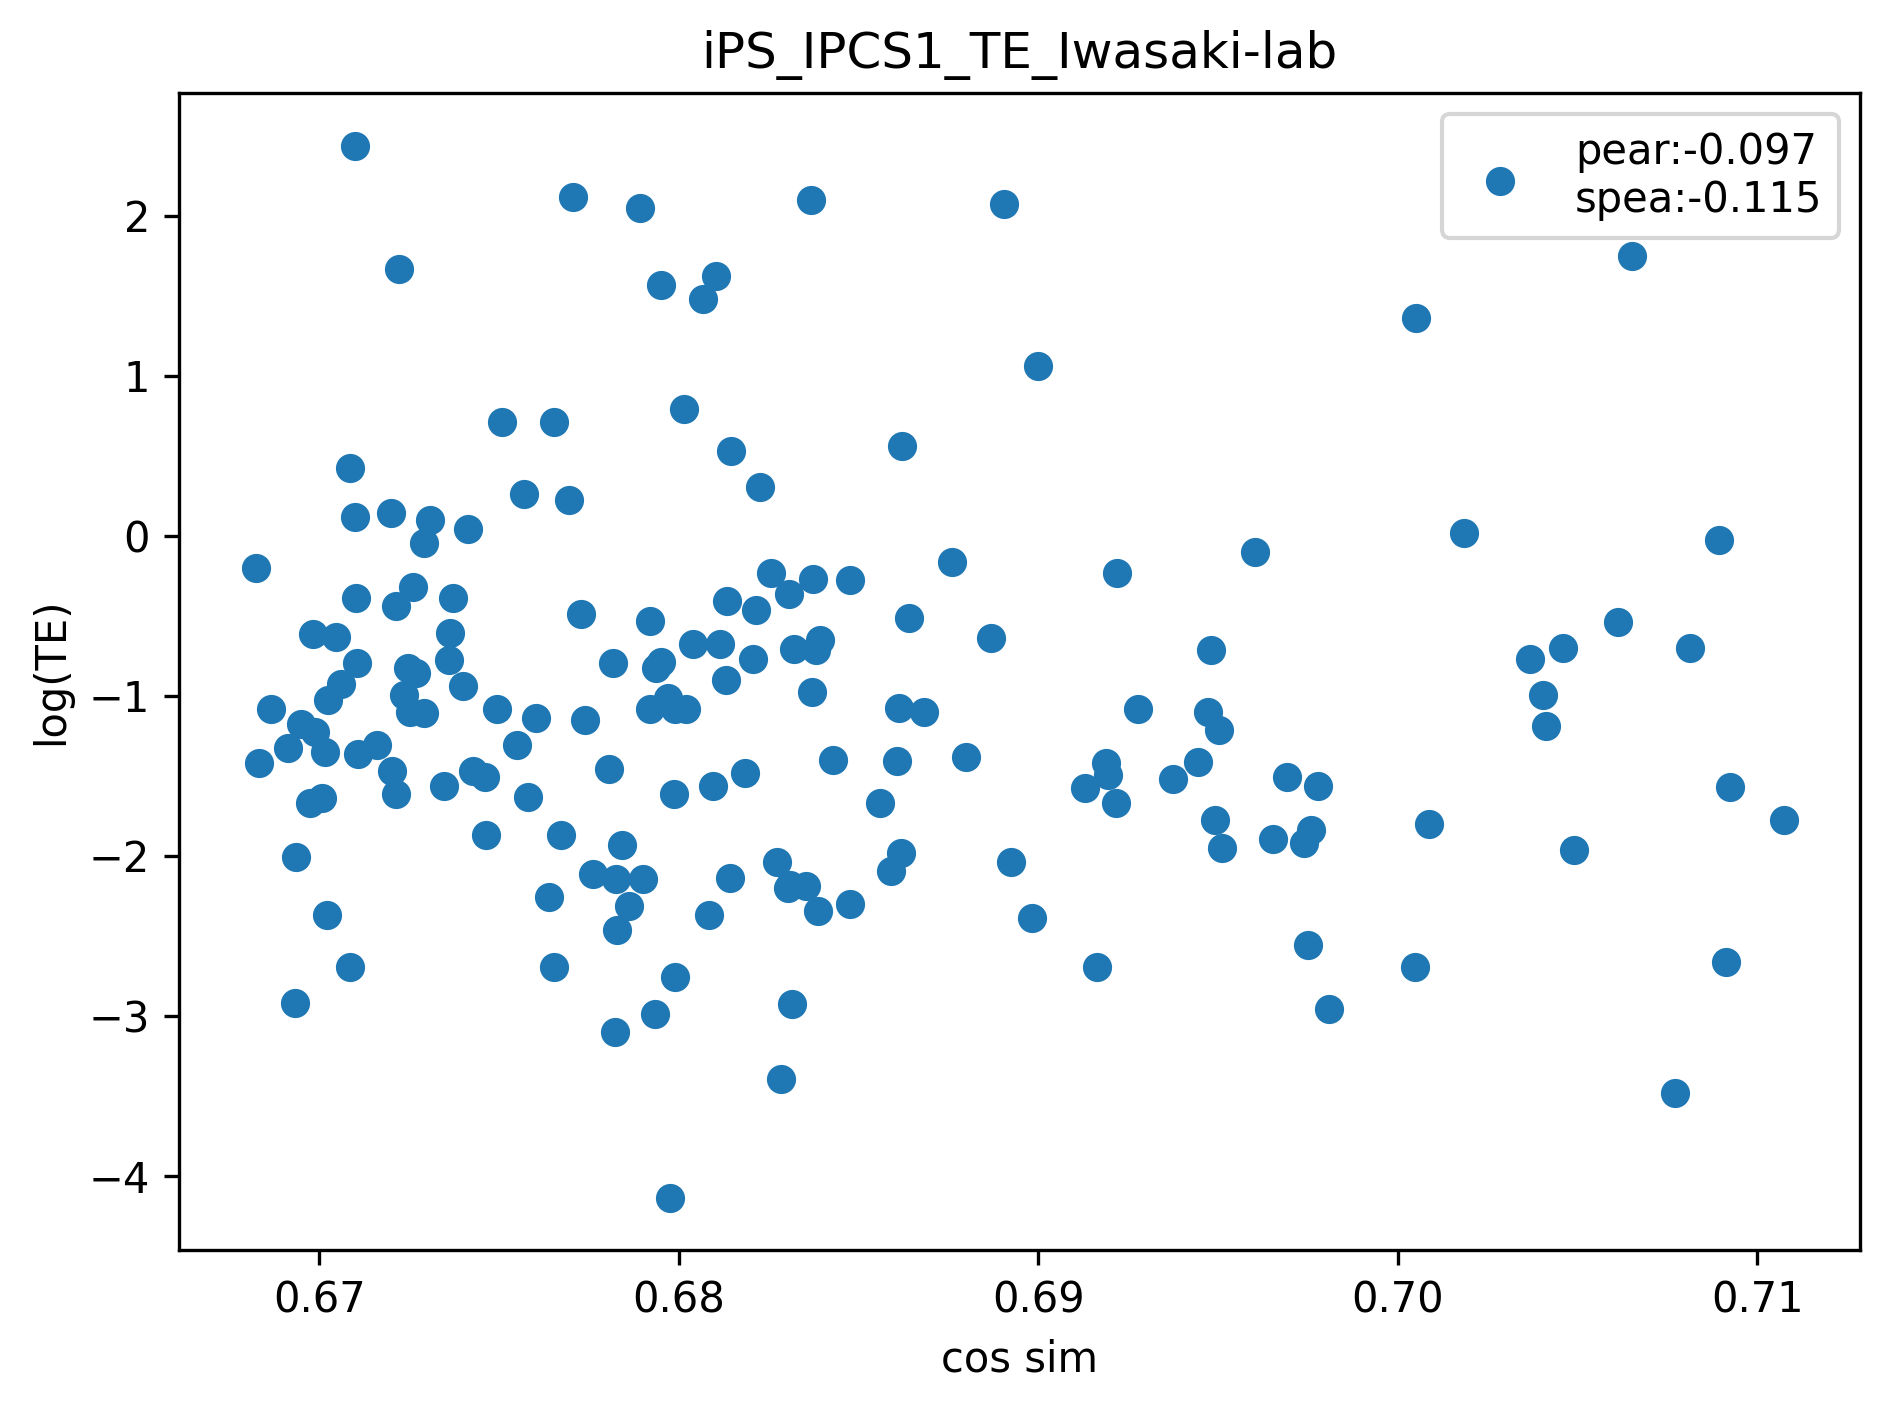

In [43]:
pred_val=df_concat["logits"].values
log_te = np.log(df_concat["TE"].values)

#plt.scatter(pred_val,log_te)
pearson,_ = pearsonr(pred_val,log_te)
spearman,_ = spearmanr(pred_val,log_te)
plt.scatter(pred_val,log_te,label=f"pear:{pearson:.3f}\nspea:{spearman:.3f}")
plt.xlabel("cos sim")
plt.ylabel("log(TE)")
plt.title("iPS_IPCS1_TE_Iwasaki-lab")
plt.legend()
plt.tight_layout()
plt.savefig("results/imgs/TE_corr_IPCS1_iwasaki_lab")
print(f"pearson:{pearson}")
print(f"spearman:{spearman}")


### 3. Analysis corr between logits and crafted_features

In [159]:
df_5utr = pd.read_csv("./data/human/gencode44_utr_gene_unique_cdhit09_max10k_feature_5utr.csv",index_col=0).iloc[:,:9]
df_3utr = pd.read_csv("./data/human/gencode44_utr_gene_unique_cdhit09_max10k_feature_3utr.csv",index_col=0).iloc[:,:9]


In [166]:
### align pred_res and feature_df with ENST_ID
target_df=df_pred_res[(df_pred_res["label"]==1)&(df_pred_res["correct"]==1)]
enst_id = target_df["ENST_ID"].values
feat_id = df_5utr.index.values
match_id = list(set(enst_id)&set(feat_id))
target_feat_df_5utr = df_5utr.loc[match_id]
target_feat_df_3utr = df_3utr.loc[match_id]
logits = target_df.set_index("ENST_ID").loc[match_id]["logits"].values


In [167]:
corr_dic = dict()

for i,c in enumerate(target_feat_df_5utr.columns):
    feat_val_utr5,feat_val_utr3 = target_feat_df_5utr.iloc[:,i].values,target_feat_df_3utr.iloc[:,i].values
    p_corr_utr5,_ =pearsonr(feat_val_utr5,logits)
    p_corr_utr3,_ =pearsonr(feat_val_utr3,logits)
    corr_dic["utr5_"+c]=p_corr_utr5
    corr_dic["utr3_"+c]=p_corr_utr3


In [168]:
score_sorted = sorted(corr_dic.items(), key=lambda x:abs(x[1]))[::-1]
score_sorted

[('utr5_energy_whole', -0.12559506245349034),
 ('utr5_G', 0.12185396579847284),
 ('utr5_C', 0.11930788715042522),
 ('utr3_CGratio', 0.0945744378704773),
 ('utr5_Length', 0.09157844755694763),
 ('utr3_ATratio', 0.07423533640034156),
 ('utr3_CGperc', 0.06088040307523814),
 ('utr3_C', 0.05179971745017227),
 ('utr5_A', 0.05171893340763698),
 ('utr3_Length', 0.04524515817151702),
 ('utr3_T', 0.043466119615473114),
 ('utr5_T', 0.043157067491293784),
 ('utr3_A', 0.042596348364294184),
 ('utr3_G', 0.03842302594890451),
 ('utr3_energy_whole', -0.035001473252464804),
 ('utr5_CGperc', -0.02087130762297756),
 ('utr5_CGratio', 0.017341756366844204),
 ('utr5_ATratio', 0.009162612246894136)]

In [66]:
# Ensembl Biomartサーバーへの接続
from biomart import BiomartServer
server = BiomartServer("http://www.ensembl.org/biomart")

# データセットのリストを取得
ensembl_genes = server.databases['ENSEMBL_MART_ENSEMBL']
ensembl_genes = server.datasets["hsapiens_gene_ensembl"]
response = ensembl_genes.search({'attributes':['go_id','ensembl_transcript_id']})
go_enst_dict = {}
enst_go_dict = {}
for line in response.iter_lines():
    line = line.decode('utf-8')
    go,enst = line.split("\t")
    if (go!='')and(enst!=''):
        go_id_list = go_enst_dict.get(go)
        enst_id_list = enst_go_dict.get(enst)
        if go_id_list==None:
            go_enst_dict[go]=[]
        else:
            go_id_list.append(enst)
        
        if enst_id_list==None:
            enst_go_dict[enst]=[]
        else:
            enst_id_list.append(go)

In [68]:
with open("go_enst_table.pkl","wb") as f:
    pickle.dump((go_enst_dict,enst_go_dict),f)

In [18]:
import pandas as pd
gencode = pd.read_csv("./data/human/gencode44_utr_gene_unique_cdhit09.csv",index_col=0)
remover = lambda x:x.split(".")[0]
gencode["ENST_ID"] = gencode["ENST_ID"].apply(remover)
gencode

,ENST_ID,GENE,5UTR,CDS,3UTR,total_len,5UTR_len,CDS_len,3UTR_len
0,ENST00000373091,GRIK3,GUGCGAGCCCGGGCGAUAGCAUCGGCGGCGGCUGGAGGAGGAGCGG...,AUGACCGCUCCCUGGCGGCGCCUCCGGAGUCUGGUUUGGGAAUACU...,GCACAGCUGGGGUGGGGACCUCAGGCCUGGGGGCUGGGCAGAGGAA...,9491,407,2760,6324
1,ENST00000291281,PRKD2,ACACUUCCUCCUGGGCCGCCGCCGCCGCCGCCGACUUAAACUUUGG...,AUGGCCACCGCCCCCUCUUAUCCCGCCGGGCUCCCUGGCUCUCCCG...,GGUCCUGUGCCCUCGUCCAGCUGCUGCCCUCCACAGCGGUUCUUCA...,3588,744,2637,207
2,ENST00000676318,LRSAM1,CGGUCCCCGUCACCCAAUCCCAGAGCCCCGCCCCUCCCCUGAGGGG...,AUGCCGCUCUUCUUCCGGAAGCGGAAACCCAGUGAGGAGGCUCGGA...,GCAUGGCCGAAAUGGAUGAACGAUUCCAGCAGAUUCUGUCGUGGCA...,5283,434,1263,3586
3,ENST00000360803,GTPBP4,GGAAGUUCCGGGAGUGCCAAGUACCCGCGUGCAUACGGCUGCCGGC,AUGGCACAUUACAACUUCAAGAAAAUUACGGUGGUGCCGUCCGCCA...,UAUCCGUUUGGUUGGCGUGGCUUCGCUAGAGUGUUGCUGUUUAUUU...,4656,46,1905,2705
4,ENST00000425053,EIF4A2,CUUUUCAGUCGGGCGCUGAGUGGUUUUUCGGAUC,AUGUCUGGUGGCUCCGCGGAUUAUAACAGAGAACAUGGCGGCCCAG...,CAGCAGUUGGUGACGAGAUGGCACUCAGAAACGGCGUUGACGUAAU...,1977,34,1089,854
...,...,...,...,...,...,...,...,...,...
16814,ENST00000343546,P4HTM,GAUACUUUUCCCGGAGGCAAGAGGGCGUCUUCACGCAGGCACCGAG...,AUGGCGGCAGCGGCGGUGACAGGCCAGCGGCCUGAGACCGCGGCGG...,GGGAAGAGUUAGCCCCGGUUCCCAGCCGCGGGUCGCCAGUUGCCCA...,2268,368,1692,208
16815,ENST00000617911,PRL,AUCCUUAUUCUAUAUCUCUUGGUAUUUAGUGUAAAAAUUUUAAAAU...,AUGAACAUCAAAGGAUCGCCAUGGAAAGCAGGGUCCCUCCUGCUGC...,GCCCACAUCCAUUUCAUCUAUUUCUGAGAAGGUCCUUAAUGAUCCG...,1364,519,687,158
16816,ENST00000262209,TRPA1,CCAGAAGUUCUCCAGGGCUUCCGCAGAGCGACUUUUUCGCUGCCUG...,AUGAAGCGCAGCCUGAGGAAGAUGUGGCGCCCUGGAGAAAAGAAGG...,CUCCUCAGACCUUCAGUGAGGCUUCUAAUGGGGGGUGCAUGACUUG...,5191,175,3360,1656
16817,ENST00000353265,PARD6G,GAGGCGCGCGGCCAGCCCAGCUCGGGCCCGCAGCACCGGGAGCAGC...,AUGAACCGAAGUUUUCACAAGUCUCAGACCUUGCGAUUCUACGAUU...,ACUCCCGAGAGGCCCCCAAAUCCUAGCUCCAGUUCCCCGGUAAGGA...,3836,166,1131,2539


In [29]:
gen_enst = gencode["ENST_ID"].values
go_enst = go_enst_dict["GO:0045596"]
match = list(set(gen_enst)&set(go_enst))
gencode.set_index("ENST_ID").loc[match]

,GENE,5UTR,CDS,3UTR,total_len,5UTR_len,CDS_len,3UTR_len
ENST_ID,,,,,,,,
ENST00000281321,POU4F2,AGUUUCGGGUGCCGAGGUCUGCAGCUAGCGGCAAGCGGAGUCAGGC...,AUGAUGAUGAUGUCCCUGAACAGCAAGCAGGCGUUUAGCAUGCCGC...,AAGACUCUUGGCCUCUCCAGAGACGCCCCUUUCCUCGUCCGCUCUU...,3144,248,1230,1666
ENST00000697200,PRAMEF7,ACCCAAAGCCCUGGUGCCUGGAACUACUGCUUGAUUCUCUGAGAGA...,AUGAGCAUCAGGGCCCCACCCAGACUCCUGGAGCUGGCAAGGCAGA...,AUGCCUGCCAUCAGGGUGGAUAUAUUUCAAGCUUUCUUCUGGUCAU...,1866,103,1425,338
ENST00000339399,ANP32B,CUUUUCCCUCCAUGGUUUCUCUCCGCUCCCGUGAGUAACUUGGCUC...,AUGGACAUGAAGAGGAGGAUCCACCUGGAGCUGAGGAACCGGACCC...,GACCCCAGAUGACCUGCAGAAACAGAACUGUUCAGUAUUGGUUGGA...,1483,215,756,512
ENST00000215832,MAPK1,AGUCUGGCAGGCAGGCAGGCAAUCGGUCCGAGUGGCUGUCGGCUCU...,AUGGCGGCGGCGGCGGCGGCGGGCGCGGGCCCGGAGAUGGUCCGCG...,AUUUGUCAGGACAAGGGCUCAGAGGACUGGACGUGCUCAGACAUCG...,5881,205,1083,4593
ENST00000223368,BCL7B,GCGACGGCCGCUGUGACGCUGCGGCGGCGGCGGGCGGGCGGCGGCG...,AUGUCGGGCCGGUCGGUCCGGGCGGAGACCCGCAGCCGGGCCAAGG...,CACCAUCCCGGCCCUCCGCCUCCUGGCCCUGCCUCUAUUUAUUGCA...,1663,112,609,942
ENST00000232424,HES1,ACACAGGAUCCGGAGCUGGUGCUGAUAACAGCGGAAUCCCCCGUCU...,AUGCCAGCUGAUAUAAUGGAGAAAAAUUCCUCGUCCCCGGUGGCUG...,GGGGGCUCAGGCCACCCCUCCUCCUAAACUCCCCAACCCACCUCUC...,1575,233,843,499
ENST00000293549,WNT1,AGACGGGCGGGAACCACAGCCCCGCUCGCUGCCCAUUGUCUGCGCC...,AUGGGGCUCUGGGCGCUGUUGCCUGGCUGGGUUUCUGCUACGCUGC...,GGCGCUGCGCGGACUCGCCCCCAGGAACGCUCUCCUCGAGCCCUCC...,2422,329,1113,980
ENST00000674681,ACTB,ACCGCCGAGACCGCGUCCGCCCCGCGAGCACAGAGCCUCGCCUUUG...,AUGGAUGAUGAUAUCGCCGCGCUCGUCGUCGACAACGGCUCCGGCA...,GCGGACUAUGACUUAGUUGCGUUACACCCUUUCUUGACAAAACCUA...,2554,87,1128,1339
ENST00000366756,DLL1,ACUGACCAUUUGGCGAUCCAUUGAGAGGAGGGUUUGGAAAAGUGGC...,AUGGGCAGUCGGUGCGCGCUGGCCCUGGCGGUGCUCUCGGCCUUGC...,AAUGGAAGUGAGAUGGCAAGACUCCCGUUUCUCUUAAAAUAAGUAA...,3779,939,2172,668


## analysis for each species from multi learning

In [56]:
## human
score_dic=dict()
thresh=np.arange(0.1,1.0,0.1)
for th in thresh:
    preds = discretize(logits,threshold=th)
    scores= metrics(preds[pair_idx[:,0]<len(seq_df)],label=pair_idx[pair_idx[:,0]<len(seq_df)][:,-1],out_logits=logits_norm[pair_idx[:,0]<len(seq_df)],phase="test")
    score_dic[th]=dict()
    for k,v in scores.items():
        if type(v)==np.float64:
            score_dic[th][k]=v

score_df = pd.DataFrame(score_dic).T
score_df


,accuracy,precision,recall,f1,auc_roc
0.1,0.542849,0.522593,0.991135,0.684350,0.716392
0.2,0.580674,0.545606,0.965130,0.697118,0.716392
0.3,0.605792,0.564435,0.926714,0.701566,0.716392
0.4,0.630615,0.585725,0.892435,0.707260,0.716392
0.5,0.647459,0.605408,0.846927,0.706085,0.716392
0.6,0.666371,0.632471,0.794326,0.704218,0.716392
0.7,0.664894,0.651795,0.708038,0.678754,0.716392
0.8,0.648345,0.668683,0.588061,0.625786,0.716392
0.9,0.606974,0.693376,0.383570,0.493912,0.716392


In [57]:
## human
score_dic=dict()
thresh=np.arange(0.1,1.0,0.1)
for th in thresh:
    preds = discretize(logits,threshold=th)
    scores= metrics(preds[pair_idx[:,0]>=len(seq_df)],label=pair_idx[pair_idx[:,0]>=len(seq_df)][:,-1],out_logits=logits_norm[pair_idx[:,0]>=len(seq_df)],phase="test")
    score_dic[th]=dict()
    for k,v in scores.items():
        if type(v)==np.float64:
            score_dic[th][k]=v

score_df = pd.DataFrame(score_dic).T
score_df


,accuracy,precision,recall,f1,auc_roc
0.1,0.534243,0.519342,0.995573,0.682603,0.733968
0.2,0.574332,0.542769,0.976204,0.697647,0.733968
0.3,0.600223,0.560720,0.947980,0.704648,0.733968
0.4,0.625278,0.580118,0.923630,0.712639,0.733968
0.5,0.646437,0.600449,0.888213,0.716518,0.733968
0.6,0.658686,0.619106,0.835639,0.711258,0.733968
0.7,0.661470,0.637891,0.756502,0.692152,0.733968
0.8,0.664254,0.670255,0.654676,0.662374,0.733968
0.9,0.638363,0.727191,0.449917,0.555897,0.733968
